# Tensorflow Tutorial on Using CNN to Train MNIST Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Load MNIST dataset downloaded from http://yann.lecun.com/exdb/mnist/
- the data file is idx file format
- Don't bother to learn what the format is, use the functions we create to tranform data into numpy arrays
- However, be sure to understand the content of numpy arrays

### Understand the content of loaded image
- We have two set of data: train set with 60000 images, test set with 100000 images
- the image size is 28 x 28, the numerical range is **normalized** to [0, 255]
- the labels are intergers from 0 to 9

Loaded of train set has an array of shape (60000, 28, 28) for images, (60000, 28, 28) for labels
Loaded of test set has an array of shape (10000, 28, 28)  for images, (10000, 1) for labels
The values of 10th label: [3]
The values of 10th image:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  42. 118. 219. 166. 118. 118.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

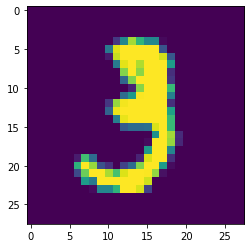

In [3]:
def extract_image(file):
    """Extract the (normalized) image from the idx file"""
    with open(file, "rb") as stream:
        stream.read(4) # header
        n_images = int.from_bytes(stream.read(4), byteorder="big")
        n_row = int.from_bytes(stream.read(4), byteorder="big")
        n_col = int.from_bytes(stream.read(4), byteorder="big")
        buf = stream.read(n_row * n_col * n_images)
        data = np.frombuffer(buf, np.uint8).astype(np.float32)
        data = data.reshape(n_images, n_row, n_col)
        return data


def extract_label(file):
    """Extract the label from the idx file"""
    with open(file, "rb") as stream:
        stream.read(4) # header
        n_labels = int.from_bytes(stream.read(4), byteorder="big")
        buf = stream.read(n_labels)
        data = np.frombuffer(buf, np.uint8)
        data = data.reshape(n_labels, 1)
        return data
    

all_train_images, all_train_labels = extract_image("./data/train-images.idx3-ubyte"), extract_label("./data/train-labels.idx1-ubyte")
test_images, test_labels = extract_image("./data/t10k-images.idx3-ubyte"), extract_label("./data/t10k-labels.idx1-ubyte")

print(f"Loaded of train set has an array of shape {all_train_images.shape} for images, {all_train_images.shape} for labels")
print(f"Loaded of test set has an array of shape {test_images.shape}  for images, {test_labels.shape} for labels")

np.set_printoptions(precision=2, suppress=True, linewidth=150, threshold=np.inf)

print(f"The values of 10th label: {all_train_labels[10, ...]}")
print(f"The values of 10th image:")
print(all_train_images[10, ...])

%matplotlib inline
plt.imshow(all_train_images[10, ...])

## Preprocess Loaded Data before Training

- Rescale the data into numerical ranges suitable for models (here we rescale to [0.0, 1.0])
- Split part of the training data into train/validation set
- One-hot the labels for calculating the cross-entropy loss

After split, train set has an array of shape (50000, 28, 28) for images, (50000, 10) for labels
After split, validation set has an array of shape (10000, 28, 28) for images, (10000, 10) for labels
The values of 10th label in train set after split: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
The values of 10th image in train set after split:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.99 1.   

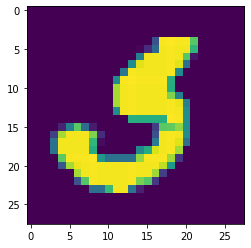

In [4]:
# Normalize the input data
all_train_images = all_train_images / 255
test_images = test_images / 255

# One-hot the label (credit: https://stackoverflow.com/questions/29831489/)
def one_hot(array, num_classes):
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

all_train_labels = one_hot(all_train_labels, 10)
test_labels = one_hot(test_labels, 10)

# Random shuffle and split part of the train set into validation set
def random_shuffle(images, labels):
    assert images.shape[0] == labels.shape[0]
    n_data = images.shape[0]
    indices = np.random.permutation(n_data)
    return images[indices, ...], labels[indices, ...]

shuffled_images, shuffled_labels = random_shuffle(all_train_images, all_train_labels)
train_images, validation_images = shuffled_images[:50000, ...], shuffled_images[50000:, ...]
train_labels, validation_labels = shuffled_labels[:50000, ...], shuffled_labels[50000:, ...]

print(f"After split, train set has an array of shape {train_images.shape} for images, {train_labels.shape} for labels")
print(f"After split, validation set has an array of shape {validation_images.shape} for images, {validation_labels.shape} for labels")

print(f"The values of 10th label in train set after split: {train_labels[10, ...]}")
print(f"The values of 10th image in train set after split:")
print(train_images[10, ...])

plt.imshow(train_images[10, ...])

## Create a Simple Convolution Network (CNN)

We select VGG16 as our example of a simple CNN. (The model type 'C' in Simonyan, K., & Zisserman, A. 2015. Very Deep Convolutional Networks for Large-Scale Image Recognition. [Arvix](https://arxiv.org/abs/1409.1556))
- Tensorflow has many [built-in models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) with ImageNet pretrained weights
- You could use built-in ones (which inlude VGG16) for your own projects, but we built VGG16 from scratch here for demonstration purpose

(source: [Neurohive](https://neurohive.io/en/popular-networks/vgg16/))
<img src="./data/vgg16_view.png" alt="" style="width: 500px;"/>
<img src="./data/vgg16_architecture.jpg" alt="" style="width: 300px;"/>

In [4]:
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import Flatten, Dense
vgg16 = tf.keras.Sequential()
vgg16.add(Input(shape=(28, 28)))
vgg16.add(Reshape(target_shape=(28, 28, 1)))  # Reshape the input as Conv2D layers expect intputs be (h, w, c), 
                                              # where c is the number of channels of the images
vgg16.add(Conv2D(filters=64, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=64, kernel_size=3, padding="same"))
vgg16.add(MaxPool2D(pool_size=(2, 2)))
vgg16.add(Conv2D(filters=128, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=128, kernel_size=3, padding="same"))
vgg16.add(MaxPool2D(pool_size=(2, 2)))
vgg16.add(Conv2D(filters=256, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=256, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=256, kernel_size=1, padding="same"))
vgg16.add(MaxPool2D(pool_size=(2, 2)))
vgg16.add(Conv2D(filters=512, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=512, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=512, kernel_size=1, padding="same"))
vgg16.add(MaxPool2D(pool_size=(2, 2)))
vgg16.add(Conv2D(filters=512, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=512, kernel_size=3, padding="same"))
vgg16.add(Conv2D(filters=512, kernel_size=1, padding="same"))
vgg16.add(GlobalMaxPool2D())
vgg16.add(Flatten())
vgg16.add(Dense(units=4096, activation="relu"))
vgg16.add(Dense(units=4096, activation="relu"))
vgg16.add(Dense(units=10, activation="softmax"))
vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0

## Training the CNN

In [5]:
n_epochs = 50
n_batch = 1024
batch_per_epoch = train_images.shape[0] // n_batch

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def single_iteration(data, label):
    with tf.GradientTape() as tp:
        logits = vgg16(data, training=True)
        loss = loss_fn(label, logits)
        
    grads = tp.gradient(loss, vgg16.trainable_weights)
    optimizer.apply_gradients(zip(grads, vgg16.trainable_weights))
    train_metrics.update_state(label, logits)
    return loss

@tf.function
def validation():
    logits = vgg16(validation_images, training=False)
    loss = loss_fn(validation_labels, logits)
    validation_metrics.update_state(validation_labels, logits)
    acc = validation_metrics.result()
    validation_metrics.reset_states()
    return loss, acc

histroy = {
    "train_losses": [],
    "train_accs": [],
    "validation_losses": [],
    "validation_accs": []
}
for epoch in range(n_epochs):
    train_images, train_labels = random_shuffle(train_images, train_labels) # Reshuffle data
    train_metrics.reset_states()
    train_loss = 0.0

    for batch in range(batch_per_epoch):
        # Sample Batch
        batch_image = train_images[batch * n_batch: (batch + 1) * n_batch, ...]
        batch_label = train_labels[batch * n_batch: (batch + 1) * n_batch, ...]
        loss = single_iteration(batch_image, batch_label)
        train_loss += loss.numpy()
    
    # Display accuracy at the end of each epoch.
    validation_loss, validation_acc = validation()
    validation_loss = validation_loss.numpy()
    validation_acc = float(validation_acc)
    train_loss = train_loss / batch_per_epoch
    train_acc = float(train_metrics.result())
    train_msg = f"Train Loss/Acc {train_loss}/{train_acc} "
    validation_msg = f"Validation Loss/Acc  {validation_loss}/{validation_acc}"
    print(f"Epoch {epoch} -- {train_msg}; {validation_msg}")

    histroy["train_losses"].append(train_loss)
    histroy["train_accs"].append(train_acc)
    histroy["validation_losses"].append(validation_loss)
    histroy["validation_accs"].append(validation_acc)

Epoch 0 -- Train Loss/Acc 2.3018909891446433/0.1119181290268898 ; Validation Loss/Acc  2.3012940883636475/0.1145000010728836
Epoch 1 -- Train Loss/Acc 2.301015928387642/0.1118570938706398 ; Validation Loss/Acc  2.3005871772766113/0.1145000010728836
Epoch 2 -- Train Loss/Acc 2.3003736237684884/0.11212158203125 ; Validation Loss/Acc  2.2999467849731445/0.1145000010728836
Epoch 3 -- Train Loss/Acc 2.2998200903336206/0.11181640625 ; Validation Loss/Acc  2.299368143081665/0.1145000010728836
Epoch 4 -- Train Loss/Acc 2.2992339630921683/0.1123860701918602 ; Validation Loss/Acc  2.298785448074341/0.1145000010728836
Epoch 5 -- Train Loss/Acc 2.298680235942205/0.1119384765625 ; Validation Loss/Acc  2.2981698513031006/0.1145000010728836
Epoch 6 -- Train Loss/Acc 2.29805755118529/0.1121826171875 ; Validation Loss/Acc  2.2974894046783447/0.1145000010728836
Epoch 7 -- Train Loss/Acc 2.2974006881316504/0.1117146834731102 ; Validation Loss/Acc  2.296722650527954/0.1145000010728836
Epoch 8 -- Train Los

## Examin the Loss Curves / Accuracy Curves

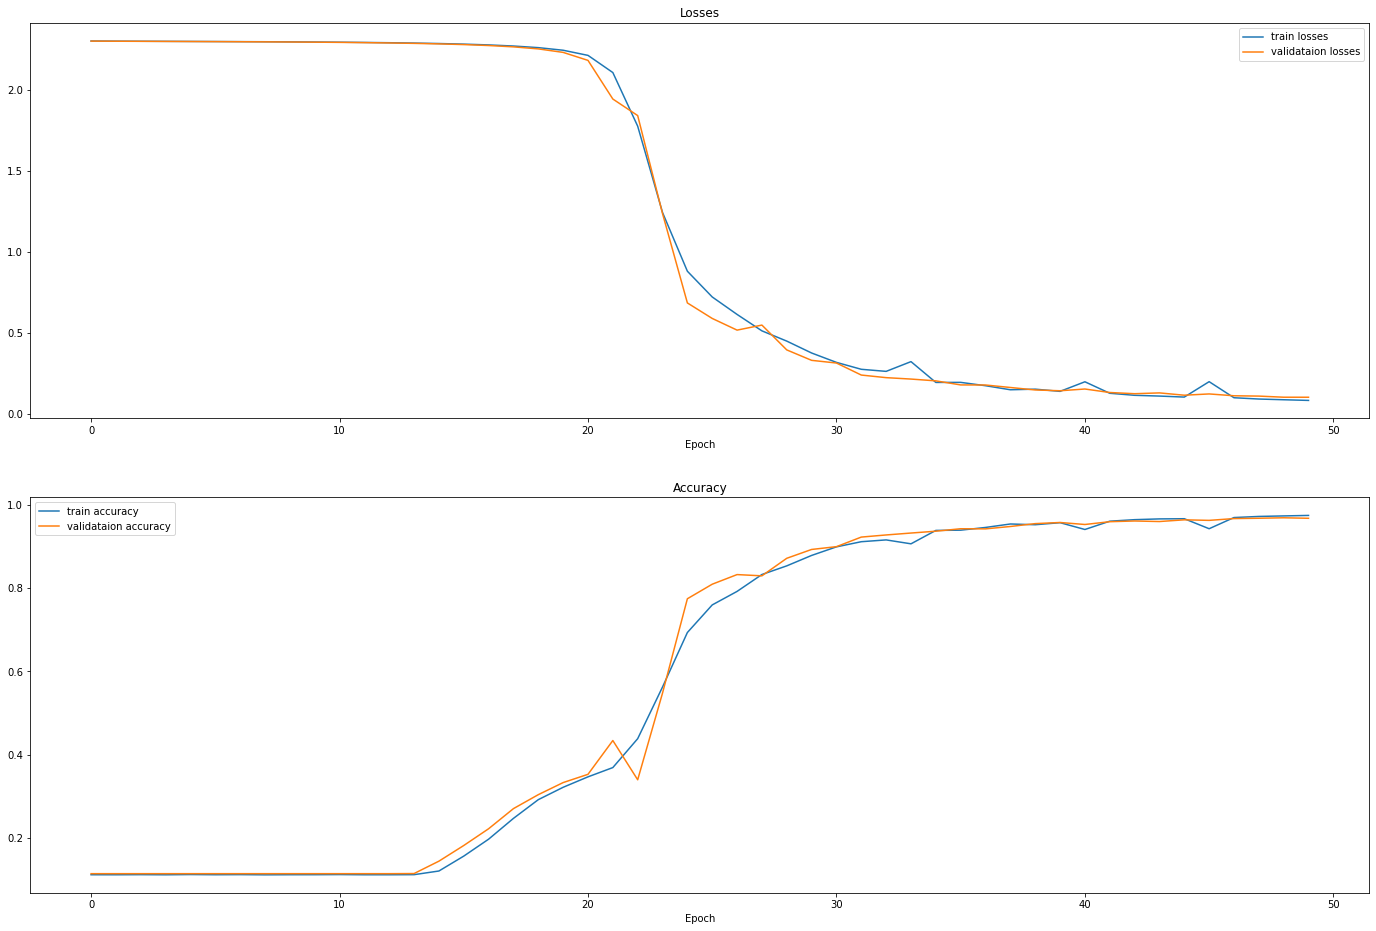

In [8]:
%matplotlib inline

fig = plt.figure(figsize=[24, 16])
ax = plt.subplot(211)
ax.plot(np.array(histroy["train_losses"]), label="train losses")
ax.plot(np.array(histroy["validation_losses"]), label="validataion losses")
ax.set_xlabel("Epoch")
ax.set_title("Losses")
ax.legend()

ax = plt.subplot(212)
ax.plot(np.array(histroy["train_accs"]), label="train accuracy")
ax.plot(np.array(histroy["validation_accs"]), label="validataion accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Accuracy")
ax.legend()

## Evaluate Data on Test Set

Test Set Loss 0.08764863014221191, Acc 0.9713000059127808
Evaluate on this specific image, model predicts 7:


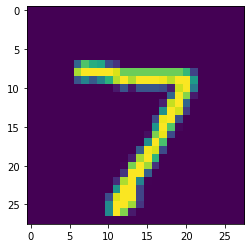

In [15]:
logits = vgg16(test_images, training=False)
test_loss = loss_fn(test_labels, logits).numpy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics.update_state(test_labels, logits)
test_acc = float(test_metrics.result())
test_metrics.reset_states()
print(f"Test Set Loss {test_loss}, Acc {test_acc}")

example_image = test_images[0, ...]
prediction = vgg16(example_image[np.newaxis, ...], training=False).numpy()
prediction = np.argmax(prediction)
print(f"Evaluate on this specific image, model predicts {prediction}:")
plt.imshow(example_image)